In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

import joblib
import pickle

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [36]:
train_df = pd.read_csv("../data/train.csv", date_parser="Date", dtype={"StateHoliday" : str})
store = pd.read_csv("../data/store.csv")

In [37]:
train_df.Store.unique()

array([   1,    2,    3, ..., 1113, 1114, 1115])

In [3]:
train_df = train_df[train_df['Open']==1].copy()

In [4]:
train_df = train_df.merge(
    store,
    how="left",
    on = "Store",
)

In [5]:
print(len(train_df))
train_df.head()

844392


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionAge,Promo2Age,IsPromo2Applied
844387,682,2,2013-01-01,3375,566,1,0,a,1,b,...,NaN,NaN,NaN,2013,1,1,1,76.0,0.000000,0
844388,733,2,2013-01-01,10765,2377,1,0,a,1,b,...,NaN,NaN,NaN,2013,1,1,1,159.0,0.000000,0
844389,769,2,2013-01-01,5035,1248,1,0,a,1,b,...,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0.0,1.213115,1
844390,948,2,2013-01-01,4491,1039,1,0,a,1,b,...,NaN,NaN,NaN,2013,1,1,1,0.0,0.000000,0
844391,1097,2,2013-01-01,5961,1405,1,0,a,1,b,...,NaN,NaN,NaN,2013,1,1,1,130.0,0.000000,0


In [6]:
train_df.isnull().mean()

Store                        0.000000
DayOfWeek                    0.000000
Date                         0.000000
Sales                        0.000000
Customers                    0.000000
Open                         0.000000
Promo                        0.000000
StateHoliday                 0.000000
SchoolHoliday                0.000000
StoreType                    0.000000
Assortment                   0.000000
CompetitionDistance          0.002589
CompetitionOpenSinceMonth    0.318121
CompetitionOpenSinceYear     0.318121
Promo2                       0.000000
Promo2SinceWeek              0.501316
Promo2SinceYear              0.501316
PromoInterval                0.501316
dtype: float64

In [7]:
def split_date(df):
  df['Date'] = pd.to_datetime(df['Date'])
  df['Year'] = df.Date.dt.year
  df['Month'] = df.Date.dt.month
  df['Day'] = df.Date.dt.day
  df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [8]:
split_date(train_df)
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31


In [9]:
def comp_months(df):
  df['CompetitionAge'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
  df['CompetitionAge'] = df['CompetitionAge'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [10]:
comp_months(train_df)
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionAge
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,2009.0,0,NaN,NaN,NaN,2015,7,31,31,70.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,2015.0,0,NaN,NaN,NaN,2015,7,31,31,3.0


In [11]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Age'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Age'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Age'] = df['Promo2Age'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Applied'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [12]:
promo_cols(train_df)
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionAge,Promo2Age,IsPromo2Applied
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,NaN,NaN,NaN,2015,7,31,31,82.0,0.000000,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0,64.131148,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0,51.901639,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,NaN,NaN,NaN,2015,7,31,31,70.0,0.000000,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,NaN,NaN,NaN,2015,7,31,31,3.0,0.000000,0


In [13]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionAge', 'Promo2Age', 'IsPromo2Applied'],
      dtype='object')

In [14]:
# train_df.to_csv("../data/train_new.csv", index=False)

In [15]:
features = ['Store', 'DayOfWeek', 'Day', 'Month', 'WeekOfYear', 'Year', 'Promo', 'StateHoliday', \
    'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionAge', \
    'IsPromo2Applied',
]

numeric_feats = ['Store', 'Day', 'Month', 'Year', 'WeekOfYear', 'Promo', 'SchoolHoliday', 'CompetitionDistance', \
    'CompetitionAge', 'IsPromo2Applied',
]

categorical_feats = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

In [16]:
inputs = train_df[features + ['Sales']].copy()

## 2. Modelisation

In [17]:
X_train = inputs.loc[inputs['Year'] != 2015, features]
y_train = inputs.loc[inputs['Year'] != 2015, 'Sales']

X_test = inputs.loc[inputs['Year'] == 2015, features]
y_test = inputs.loc[inputs['Year'] == 2015, 'Sales']




print("Training data length : ", len(X_train))
print("Test data length : ", len(X_test))

Training data length :  648360
Test data length :  196032


### 2.1. Preprocessing

#### 2.1.1. Missing Values

In [18]:
len(X_test) / len(inputs)

0.23215757610209475

In [19]:
X_train[numeric_feats].isna().sum()

Store                     0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
Promo                     0
SchoolHoliday             0
CompetitionDistance    1660
CompetitionAge            0
IsPromo2Applied           0
dtype: int64

In [20]:
X_test[numeric_feats].isna().sum()

Store                    0
Day                      0
Month                    0
Year                     0
WeekOfYear               0
Promo                    0
SchoolHoliday            0
CompetitionDistance    526
CompetitionAge           0
IsPromo2Applied          0
dtype: int64

In [21]:
max_distance = X_train.CompetitionDistance.max()
max_distance

75860.0

In [22]:
X_train['CompetitionDistance'].fillna(max_distance * 10, inplace=True)
X_test['CompetitionDistance'].fillna(max_distance * 10, inplace=True)

In [23]:
X_train[numeric_feats].isna().sum()

Store                  0
Day                    0
Month                  0
Year                   0
WeekOfYear             0
Promo                  0
SchoolHoliday          0
CompetitionDistance    0
CompetitionAge         0
IsPromo2Applied        0
dtype: int64

In [24]:
X_test[numeric_feats].isna().sum()

Store                  0
Day                    0
Month                  0
Year                   0
WeekOfYear             0
Promo                  0
SchoolHoliday          0
CompetitionDistance    0
CompetitionAge         0
IsPromo2Applied        0
dtype: int64

### 2.2. Pipeline

In [30]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000,
                    learning_rate=0.3, max_depth=5, subsample=0.9,
                    colsample_bytree=0.7, reg_lambda=0.8
)
                    
preprocessor = ColumnTransformer([
    ("scaler", MinMaxScaler(), numeric_feats),
    ("encoder", OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_feats)
])

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model)
])

In [70]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['Store', 'Day', 'Month',
                                                   'Year', 'WeekOfYear',
                                                   'Promo', 'SchoolHoliday',
                                                   'CompetitionDistance',
                                                   'CompetitionAge',
                                                   'IsPromo2Applied']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['DayOfWeek', 'StateHoliday',
                                                   'StoreType',
                                                   'Assortment'])])),
       

In [26]:
encoded_cols = list(pipeline.named_steps["preprocessor"].named_transformers_["encoder"].get_feature_names(categorical_feats))
columns = numeric_feats + encoded_cols

In [72]:
rmse_test = mean_squared_error(y_test, pipe.predict(X_test) ,squared=False)
rmse_test

1161.0398790092613

In [71]:
rmse_train = mean_squared_error(y_train, pipe.predict(X_train) ,squared=False)
rmse_train

788.1835196130369

In [74]:
rmse_train / y_train.mean()

0.11397480531193113

In [75]:
rmse_test / y_test.mean()

0.16380066789404962

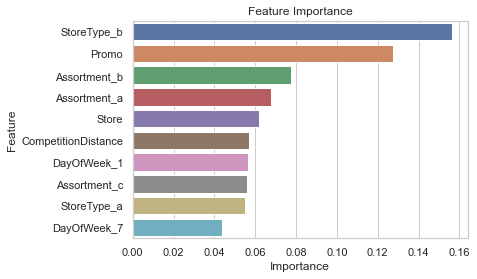

In [76]:
importance_df = pd.DataFrame({
    'feature': columns,
    'importance': pipe.named_steps["model"].feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature');

In [77]:
joblib.dump(pipe, '../model/pipeline.pkl')

['../model/pipeline.pkl']

In [25]:
pipeline = joblib.load('../model/pipeline.pkl')

In [26]:
mean_squared_error(y_test, pipeline.predict(X_test) ,squared=False)

1161.0398790092613

## Interpretation de la performance du modèle

In [84]:
test = pd.concat([X_test, y_test], axis=1)
df_1 = test.loc[train_df['Store'] == 2]

In [85]:
df_1_pred_sales = pipeline.predict(df_1[features])

In [86]:
def getDate(row):
    row["Date"] = dt.date(row.Year, row.Month, row.Day)
    return row

df_1 = df_1.apply(getDate, axis=1)
df_1["pred_Sales"] = df_1_pred_sales

No handles with labels found to put in legend.


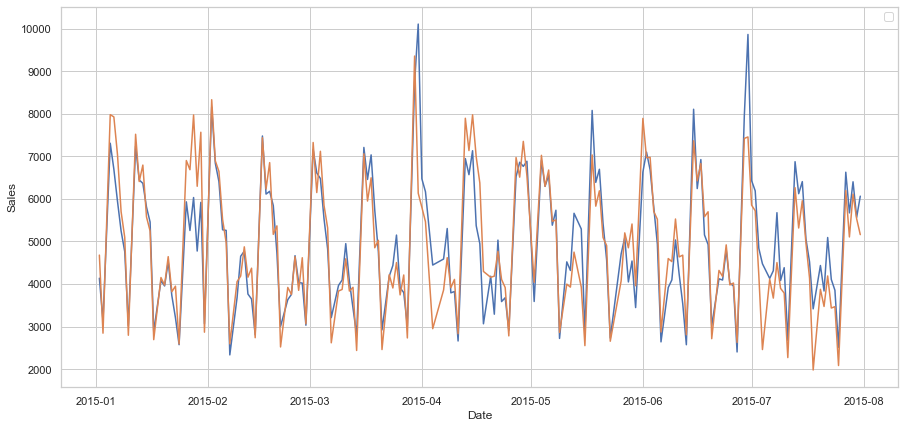

In [87]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_1, x='Date', y='Sales')
sns.lineplot(data=df_1, x='Date', y='pred_Sales')
plt.legend()

### SHAP Values

In [27]:
import shap

In [28]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['Store', 'Day', 'Month',
                                                   'Year', 'WeekOfYear',
                                                   'Promo', 'SchoolHoliday',
                                                   'CompetitionDistance',
                                                   'CompetitionAge',
                                                   'IsPromo2Applied']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['DayOfWeek', 'StateHoliday',
                                                   'StoreType',
                                                   'Assortment'])])),
       

In [28]:
X_test_processed = pd.DataFrame(pipeline['preprocessor'].transform(X_test), columns=columns)
X_test_processed

,Store,Day,Month,Year,WeekOfYear,Promo,SchoolHoliday,CompetitionDistance,CompetitionAge,IsPromo2Applied,...,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,0.000000,1.0,0.545455,2.0,0.588235,1.0,1.0,0.001648,0.059723,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.000898,1.0,0.545455,2.0,0.588235,1.0,1.0,0.000725,0.067007,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.001795,1.0,0.545455,2.0,0.588235,1.0,1.0,0.018601,0.075018,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.002693,1.0,0.545455,2.0,0.588235,1.0,1.0,0.000791,0.050983,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.003591,1.0,0.545455,2.0,0.588235,1.0,1.0,0.039403,0.002185,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196027,0.657092,0.0,0.000000,2.0,0.000000,0.0,1.0,0.001107,0.133285,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
196028,0.689408,0.0,0.000000,2.0,0.000000,0.0,1.0,0.001081,0.000000,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
196029,0.850090,0.0,0.000000,2.0,0.000000,0.0,1.0,0.001859,0.000000,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
196030,0.969479,0.0,0.000000,2.0,0.000000,0.0,1.0,0.000501,0.077203,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


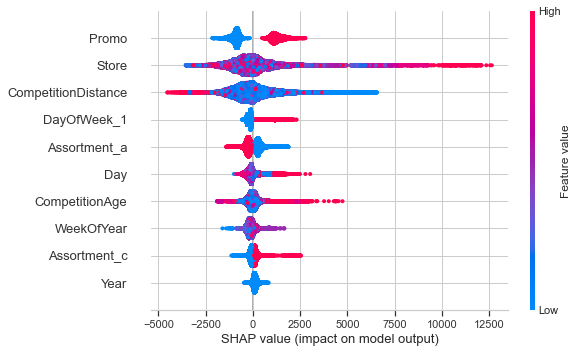

In [32]:
#load JS vis in the notebook
shap.initjs() 

#set the tree explainer as the model of the pipeline
explainer = shap.TreeExplainer(pipeline['model'])

#apply the preprocessing to x_test
observations = pipeline['preprocessor'].transform(X_test)

#get Shap values from preprocessed data
shap_values = explainer.shap_values(observations)

#plot the feature importance
shap.plots.beeswarm(shap_values, X_test_processed, max_display=10)

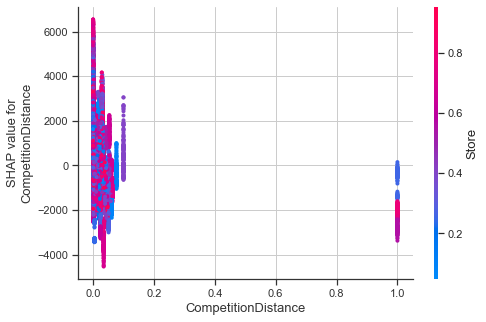

In [34]:
shap.dependence_plot("CompetitionDistance", shap_values, X_test_processed)